# Lab 8 Report: 
## FINAL PROJECT STRATEGIC PLANNING

### Lab 8 Instruction: https://canvas.uw.edu/courses/1548925/files/92225287?wrap=1

### Team Members:

### Dataset for your project:

#### Feel free to delete or modify pre-written markdown cells below the line

---

## Understanding the Data

In [1]:
%matplotlib inline

import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import seaborn as sns
sns.set(style = 'white', font_scale = 1.5)

In [4]:
device = torch.device("mps")

In [5]:
hdf = h5py.File('/content/drive/MyDrive/CCSN_Pan_SNR_Free_Test_Validation.h5', 'r') #Reading the file
keys = list(hdf.keys()) #Listing the file keys
print(keys)

['Dis', 'Model_FR', 'Model_NR', 'Model_SR', 'Noise']


In [6]:
for key in keys: #Listing the datasets within each key
    print(key,":")
    for k in hdf[key]:
        print(k)
    print()

Dis :

Model_FR :
Hp

Model_NR :
Dis
Hp

Model_SR :
Hp

Noise :
Strain



In [7]:
signal_nr = hdf['Model_NR']['Hp'] #Reading each dataset
signal_sr = hdf['Model_SR']['Hp']
signal_fr = hdf['Model_FR']['Hp']
noise = hdf['Noise']['Strain']

In [8]:
signal_nr_np = np.array(signal_nr) #Converting to numpy array
signal_sr_np = np.array(signal_sr)
signal_fr_np = np.array(signal_fr)
noise_np = np.array(noise)

In [9]:
print("Signal NR Shape: ", signal_nr_np.shape) #Displaying the shapes
print("Signal SR Shape: ", signal_sr_np.shape)
print("Signal FR Shape: ", signal_fr_np.shape)
print("Noise Shape: ", noise_np.shape)

Signal NR Shape:  (6250, 8192)
Signal SR Shape:  (6250, 8192)
Signal FR Shape:  (6250, 8192)
Noise Shape:  (18750, 8192)


In [10]:
nan_values_nr = np.isnan(signal_nr_np) #Checking for missing values
nan_values_sr = np.isnan(signal_sr_np)
nan_values_fr = np.isnan(signal_fr_np)
nan_values_noise = np.isnan(noise_np)

In [11]:
print(np.unique(nan_values_nr, return_counts = True))
print(np.unique(nan_values_sr, return_counts = True))
print(np.unique(nan_values_fr, return_counts = True))
print(np.unique(nan_values_noise, return_counts = True))

(array([False]), array([51200000]))
(array([False]), array([51200000]))
(array([False]), array([51200000]))
(array([False]), array([153600000]))


The results of the above cells demonstrate the dimensions of the signal datasets are (6250,8192) and noise is (18750,8192). Additionally, there is no missing data therefore there is no need for imputation.

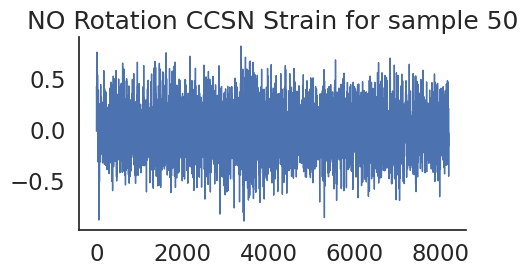

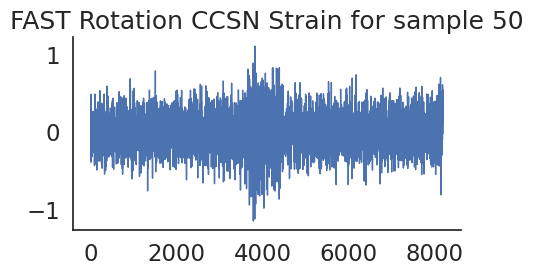

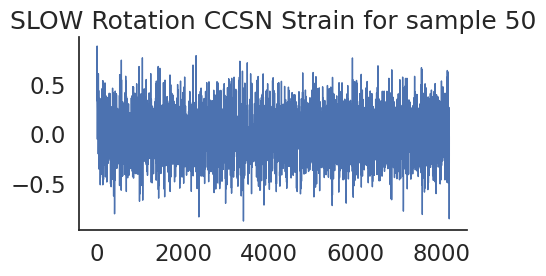

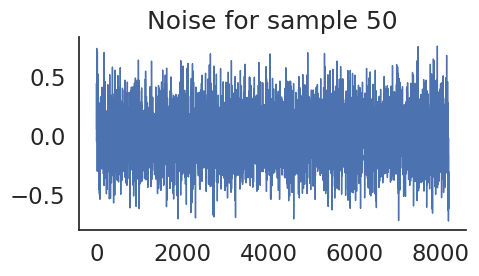

In [12]:
sample = 50

plt.figure(figsize = (5, 2.5))
plt.plot(signal_nr_np[sample], linewidth = 1)
plt.title('NO Rotation CCSN Strain for sample '+str(sample))
sns.despine()

# fr
plt.figure(figsize = (5, 2.5))
plt.title('FAST Rotation CCSN Strain for sample '+str(sample))
plt.plot(signal_fr_np[sample], linewidth = 1)
sns.despine()

#sr
plt.figure(figsize = (5, 2.5))
plt.title('SLOW Rotation CCSN Strain for sample '+str(sample))
plt.plot(signal_sr_np[sample], linewidth = 1)
sns.despine()

# noise
plt.figure(figsize = (5, 2.5))
plt.title('Noise for sample '+str(sample))
plt.plot(noise_np[sample], linewidth = 1)
sns.despine()

In [13]:
signals = np.vstack((signal_nr_np, signal_sr_np, signal_fr_np)) #Stacking the signals
signals.shape

(18750, 8192)

In [14]:
X = np.vstack((signals, noise_np)) #Creating our input matrix
X.shape

(37500, 8192)

In [15]:
y = np.concatenate((np.ones(18750, dtype = int), np.zeros(18750, dtype = int))) #Creating our output
y.shape

(37500,)

In [16]:
from sklearn.model_selection import train_test_split #Creating the training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [17]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [18]:
#Splitting train into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 42)

## Understanding the Task

This task is a binary classification where true signals are 1 and noise is 0. We can proceed to training via a binary classification neural network that uses two 1d convolutional layers combined with a max pool.

## Developing an initial plan for your project

In [19]:
#Creating a neural network
class signalClassification(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(signalClassification, self).__init__()
        
        
        self.conv1 = torch.nn.Conv1d(in_channels = 1, out_channels = 8, kernel_size = 16) #The Conv1d layers
        self.pool1 = torch.nn.MaxPool1d(kernel_size = 4)

        self.conv2 = torch.nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = 16)
        self.pool2 = torch.nn.MaxPool1d(kernel_size = 4)

        
        self.layer1 = torch.nn.Linear(input_dim, hidden_dim_1) #FCN
        self.layer2 = torch.nn.Linear(hidden_dim_1, hidden_dim_2)
        self.layer3 = torch.nn.Linear(hidden_dim_2, output_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim_1)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim_2)
        self.dropout = torch.nn.Dropout(p = 0.1)
        
    def forward(self, x):
        
        conv1out = torch.nn.functional.relu(self.conv1(x))
        pool1out = self.pool1(conv1out)

        conv2out = torch.nn.functional.relu(self.conv2(pool1out))
        pool2out = self.pool2(conv2out)
        
        fcn_input = pool2out.view(pool2out.size(0), -1)
        
        out1 = torch.nn.functional.relu(self.layer1(fcn_input))
        out1 = self.bn1(out1) #Using batch normalization and dropout to prevent overfitting
        out1 = self.dropout(out1)
        out2 = torch.nn.functional.relu(self.layer2(out1))
        out2 = self.bn2(out2)
        out2 = self.dropout(out2)
        out = self.layer3(out2)
        
        return out

In [20]:
model = signalClassification(input_dim = 8112, hidden_dim_1 = 1024, hidden_dim_2 = 8, output_dim = 1)# YOUR CODE HERE

# Define the learning rate and epoch 
learning_rate = 0.001 
epochs = 3 #Only using 3 epochs because the model begins to overfit
batchsize = 2000 # YOUR CODE HERE (If you are using mini-batch gradient)

# Define loss function and optimizer
loss_func = torch.nn.BCEWithLogitsLoss() #Has sigmoid function within it
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # YOUR CODE HERE


model

signalClassification(
  (conv1): Conv1d(1, 8, kernel_size=(16,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(8, 16, kernel_size=(16,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (layer1): Linear(in_features=8112, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=1, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [21]:
train_loss_list = [] #Keeping track of training loss and validation accuracy
validation_accuracy_list = []

In [22]:
X_train = torch.from_numpy(X_train.reshape(-1,1,8192)).float() #Converting numpy arrays to torch tensors and following the torch pattern (N, Channels, Length)
X_train = torch.split(X_train, batchsize) #Splitting into batches
y_train = torch.from_numpy(y_train.reshape(-1,1)).float()
y_train = torch.split(y_train, batchsize)

batch_split_num = len(X_train)

X_val = torch.from_numpy(X_val.reshape(-1,1,8192)).float()
y_val = torch.from_numpy(y_val.reshape(-1,1)).float()

X_test = torch.from_numpy(X_test.reshape(-1,1,8192)).float()
y_test = torch.from_numpy(y_test.reshape(-1,1)).float()

In [23]:
for epoch in range(epochs): #Training the model
    
    for i in range(batch_split_num):
        optimizer.zero_grad()

        train_outputs = model(X_train[i])

        loss = loss_func(train_outputs, y_train[i]) 

        train_loss_list.append(loss.item())

        loss.backward()

        optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))
    
    # Compute Validation Accuracy ----------------------------------------------------------------------
    
    # YOUR CODE HERE
    with torch.no_grad():
        
        validation_outputs = model(X_val)
        
        validation_outputs = torch.sigmoid(validation_outputs) #Applying sigmoid
    
        correct = (torch.round(validation_outputs) == y_val).type(torch.FloatTensor) #Rounding to 0 or 1
        
        validation_accuracy_list.append(correct.mean())
        
        print(correct.mean())

epoch 0, loss 0.3667835593223572
tensor(0.8601)
epoch 1, loss 0.30339863896369934
tensor(0.8712)
epoch 2, loss 0.2510746121406555
tensor(0.8798)


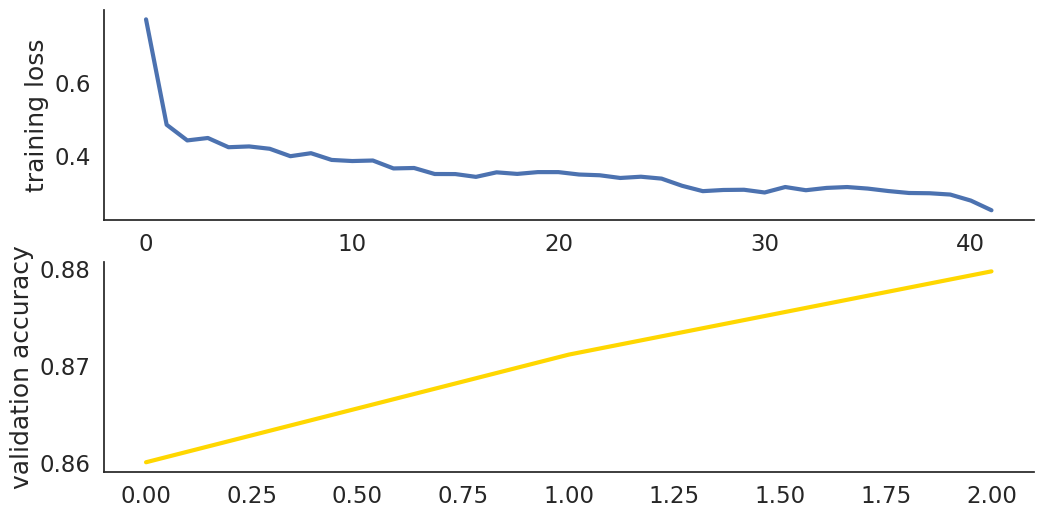

In [24]:
plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [25]:
with torch.no_grad(): #Testing accuracy appears to be 87.6%
    test_outputs = model(X_test)
    test_outputs = torch.sigmoid(test_outputs)
    correct = (torch.round(test_outputs) == y_test).type(torch.FloatTensor)
    print("Accuracy: "+str(correct.mean().numpy()*100)+"%")

Accuracy: 87.64444589614868%
